In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
import optuna

# STATISTICS
from statsmodels.graphics.gofplots import qqplot

# HYPOTHESIS TESTING
from scipy.stats import ks_2samp

from tempfile import mkdtemp

# Sklearn preprocessing
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor,StackingRegressor,RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error




#notebook settings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [85]:
# Load data
train = pd.read_csv('data/train.csv',index_col=0)
test = pd.read_csv('data/test.csv',index_col=0)
sub = pd.read_csv('data/sample_submission.csv',index_col=0)

In [86]:
# summary statistics
summary_table = pd.DataFrame(train.dtypes, columns=['dtypes'])
summary_table['Missing'] = train.isnull().sum()
summary_table['Unique'] = train.nunique()
summary_table['Count'] = train.count()
summary_table['Duplicated'] = train.duplicated().sum()
summary_table

,dtypes,Missing,Unique,Count,Duplicated
Sex,object,0,3,90615,0
Length,float64,0,157,90615,0
Diameter,float64,0,126,90615,0
Height,float64,0,90,90615,0
Whole weight,float64,0,3175,90615,0
Whole weight.1,float64,0,1799,90615,0
Whole weight.2,float64,0,979,90615,0
Shell weight,float64,0,1129,90615,0
Rings,int64,0,28,90615,0


In [87]:
# check the distribution of sex
categorical_features = train.select_dtypes(include=['object']).copy()
categorical_features.value_counts(normalize=True)

Sex
I      0.365204
M      0.342405
F      0.292391
Name: proportion, dtype: float64

In [88]:
numerical_features = train.select_dtypes(exclude=['object']).copy()

In [89]:
def plot_numerical_features(data):
    """
    Plot the distribution, boxplot, and Gaussianity of numerical features in the given dataset.

    Args:
        data (pandas.DataFrame): The dataset containing numerical features.

    Returns:
        None
    """
    data = data.copy()
    
    # drop target variable, customer id, and surname
    data.drop(columns=['Rings'], inplace=True)
    
    X_num = data.select_dtypes(exclude='object')
    
    for numerical_feature in data.columns:
        
        # Creating three subplots per numerical_feature
        fig, ax =plt.subplots(1,3,figsize=(15,3))
        
        # Histogram to get an overview of the distribution of each numerical_feature
        ax[0].set_title(f"Distribution of: {numerical_feature}")
        sns.histplot(data = X_num, x = numerical_feature, kde=True, ax = ax[0])
        
        # Boxplot to detect outliers
        ax[1].set_title(f"Boxplot of: {numerical_feature}")
        sns.boxplot(data = X_num, x = numerical_feature, ax=ax[1])
        
        # Analyzing whether a feature is normally distributed or not
        ax[2].set_title(f"Gaussianity of: {numerical_feature}")
        qqplot(X_num[numerical_feature],line='s',ax=ax[2])


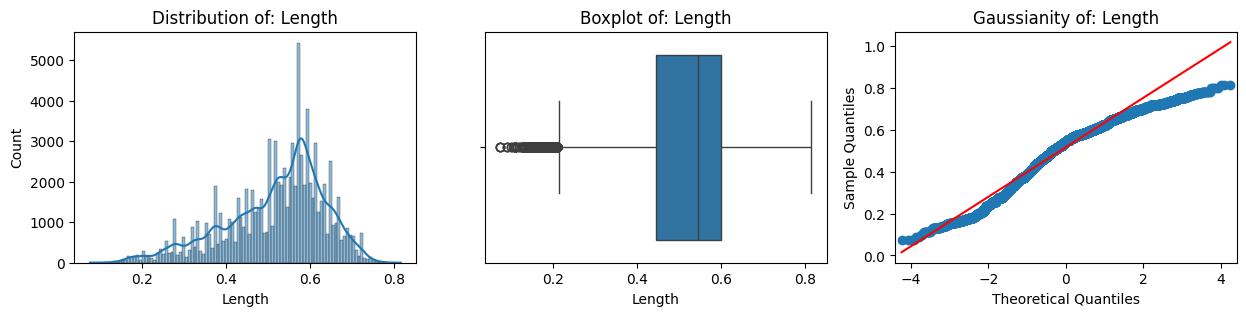

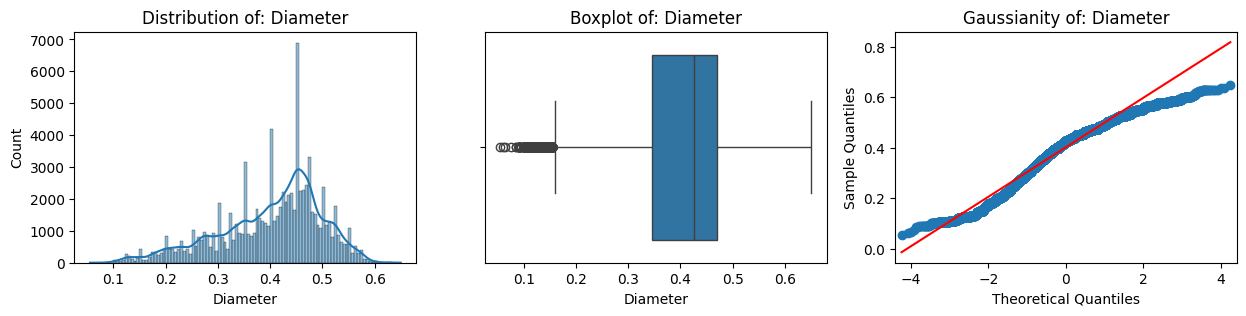

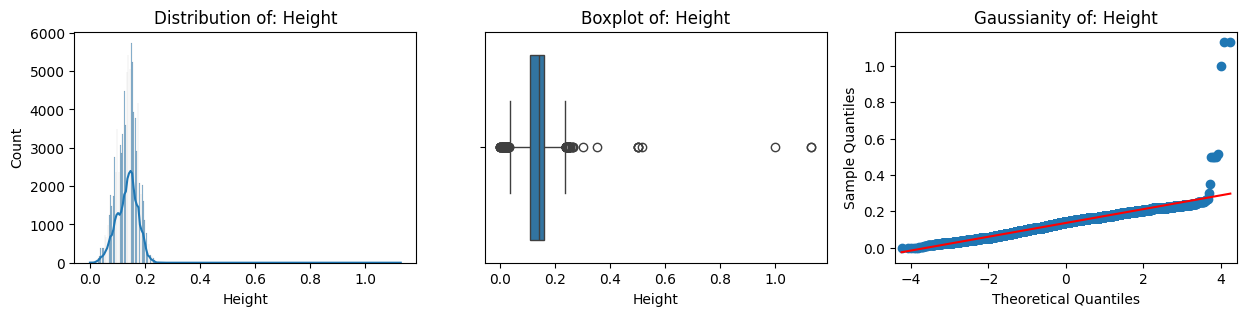

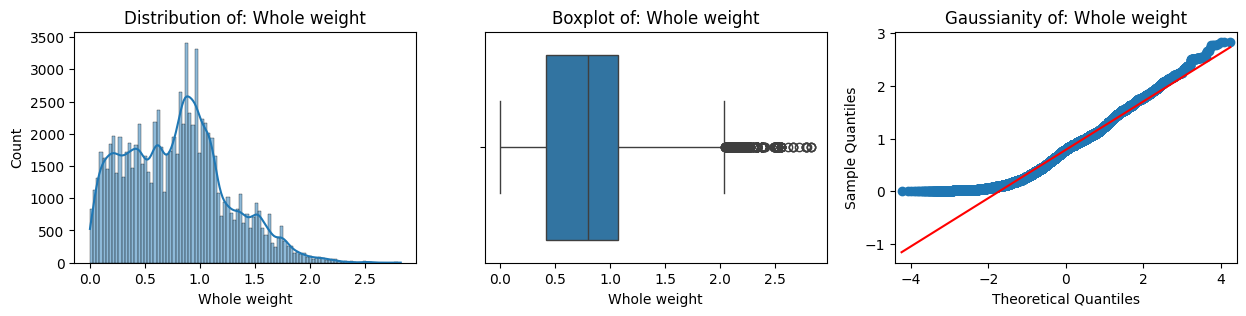

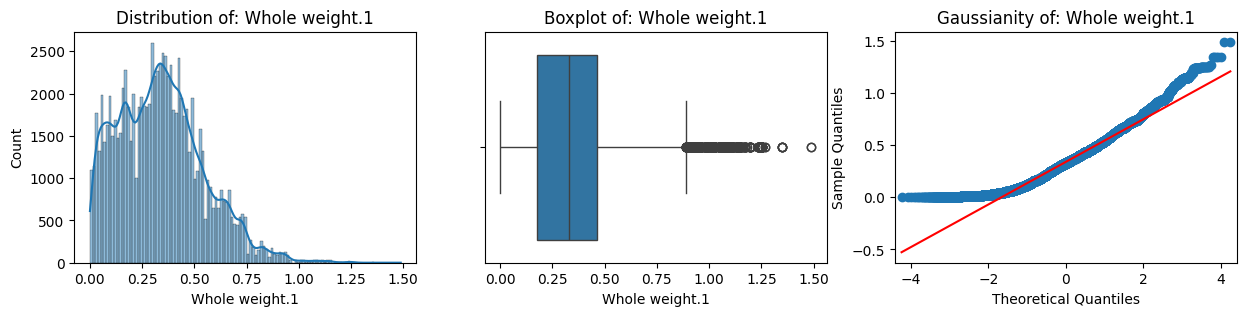

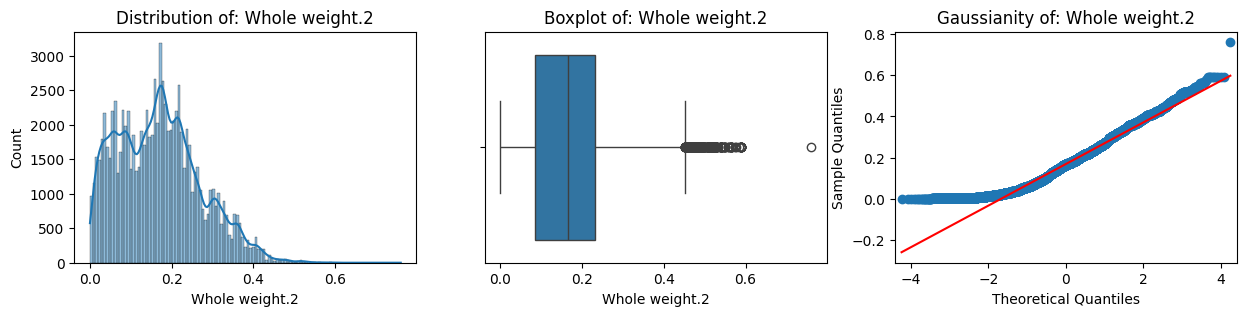

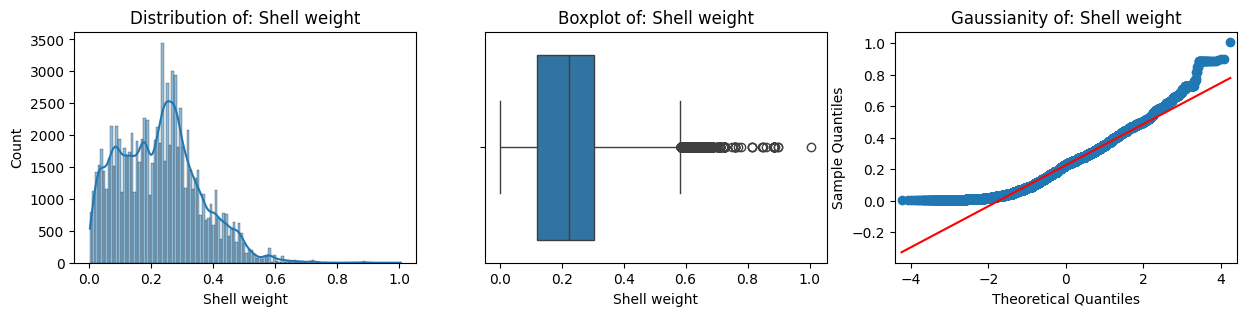

In [90]:
plot_numerical_features(numerical_features)

In [91]:
def choose_scaler_for_features(data):
    """
    Choose the appropriate scaler for each feature in a DataFrame.

    Parameters:
    data (DataFrame): DataFrame containing numerical features.

    Returns:
    dict: Dictionary mapping feature names to recommended scalers.
    """

    # Initialize a dictionary to store recommended scalers for each feature
    scalers = {}

    # Loop through each feature
    for feature in data.columns:
        feature_data = data[feature]

        # Fit data with different scalers
        minmax_scaled = MinMaxScaler().fit_transform(feature_data.values.reshape(-1, 1)).flatten()
        standard_scaled = StandardScaler().fit_transform(feature_data.values.reshape(-1, 1)).flatten()
        robust_scaled = RobustScaler().fit_transform(feature_data.values.reshape(-1, 1)).flatten()

        # Perform Kolmogorov-Smirnov test between original and scaled data
        ks_minmax = ks_2samp(feature_data, minmax_scaled).statistic
        ks_standard = ks_2samp(feature_data, standard_scaled).statistic
        ks_robust = ks_2samp(feature_data, robust_scaled).statistic

        # Choose the scaler with the lowest KS statistic
        if ks_minmax <= ks_standard and ks_minmax <= ks_robust:
            scalers[feature] = "minmax"
        elif ks_standard <= ks_minmax and ks_standard <= ks_robust:
            scalers[feature] = "standard"
        else:
            scalers[feature] = "robust"

    return scalers

In [92]:
X = train.drop('Rings', axis=1)
y = train['Rings']

In [93]:
X_num = X.select_dtypes(exclude='object')

# Choose scalers for features
scalers = choose_scaler_for_features(X_num)

print("Recommended scalers for each feature:")
scalers

Recommended scalers for each feature:


{'Length': 'minmax',
 'Diameter': 'standard',
 'Height': 'minmax',
 'Whole weight': 'standard',
 'Whole weight.1': 'minmax',
 'Whole weight.2': 'minmax',
 'Shell weight': 'minmax'}

In [94]:
minmax_list = [key for key, value in scalers.items() if value == 'minmax']
standard_list = [key for key, value in scalers.items() if value == 'standard']
robust_list = [key for key, value in scalers.items() if value == 'robust']

In [95]:
# Preprocessing pipeline for numerical features
numerical_pipeline = Pipeline([
    ('scaler', ColumnTransformer([
        ('minmax', MinMaxScaler(), minmax_list),
        ('standard', StandardScaler(), standard_list),
        ('robust', RobustScaler(), robust_list)
    ])
    )
])

# Preprocessing pipeline for categorical features
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine numerical and categorical pipelines
preprocessing = ColumnTransformer([
    ('numerical', numerical_pipeline, X_num.columns),
    ('categorical', categorical_pipeline, X.select_dtypes(include='object').columns)
])

# Fit and transform the training data
X_preprocessed = preprocessing.fit_transform(X)

# Transform the test data
X_test_preprocessed = preprocessing.transform(test)

In [96]:
preprocessing

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('scaler',
                                                  ColumnTransformer(transformers=[('minmax',
                                                                                   MinMaxScaler(),
                                                                                   ['Length',
                                                                                    'Height',
                                                                                    'Whole '
                                                                                    'weight.1',
                                                                                    'Whole '
                                                                                    'weight.2',
                                                                                    'Shell '
                                                                                    'weight']),
                                                                                  ('standard',
                                                                                   StandardScaler(),
                                                                                   ['Diameter',
                                                                                    'Whole '
                                                                                    'weight']),
                                                                                  ('robust',
                                                                                   RobustScaler(),
                                                                                   [])]))]),
                                 Index(['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['Sex'], dtype='object'))])

In [102]:
# define a optuna objective function
def objective(trial):
    # define the search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }
    
    # Initialize XGBoost model with suggested hyperparameters
    model = xgb.XGBRegressor(**params)
    
    # fit model
    xgb_pipe = Pipeline([
        ('preprocessing', preprocessing),
        ('xgboost', model)
    ])
    
    scores = -1 * cross_val_score(xgb_pipe,
                                    X,
                                    y,
                                    cv=KFold(n_splits=5, shuffle=True, random_state=42),
                                    scoring='neg_root_mean_squared_log_error')
    
    return scores.mean()

In [103]:
# perform hyperparameter optimization with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print('\n----------------------------------------\n')
print(f'Best trial: {study.best_trial.params}')
print(f'Best score: {study.best_value}')

[I 2024-04-02 10:44:31,409] A new study created in memory with name: no-name-c54c22c6-95a8-448a-9dca-ca8320fef2e4
[I 2024-04-02 10:44:37,959] Trial 0 finished with value: 0.15070985410121213 and parameters: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2045814175951863, 'subsample': 0.998348968579102, 'colsample_bytree': 0.9930604146372678, 'gamma': 0.12943715390674038, 'reg_alpha': 0.8593085622845499, 'reg_lambda': 0.1183733525622338}. Best is trial 0 with value: 0.15070985410121213.
[I 2024-04-02 10:44:45,418] Trial 1 finished with value: 0.1503298019328906 and parameters: {'n_estimators': 700, 'max_depth': 3, 'learning_rate': 0.22335241625990263, 'subsample': 0.7752893658577329, 'colsample_bytree': 0.9953678698741206, 'gamma': 0.8889668211787882, 'reg_alpha': 0.897033454669359, 'reg_lambda': 0.9095244794903696}. Best is trial 1 with value: 0.1503298019328906.
[I 2024-04-02 10:44:55,994] Trial 2 finished with value: 0.15169165625118278 and parameters: {'n_estimators': 900,


----------------------------------------

Best trial: {'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.03027074429236892, 'subsample': 0.7394402975375475, 'colsample_bytree': 0.6981159278882985, 'gamma': 0.32874261117384085, 'reg_alpha': 0.16698854328944887, 'reg_lambda': 0.737359542353077}
Best score: 0.14950284282830545


In [104]:
study.best_params

{'n_estimators': 600,
 'max_depth': 7,
 'learning_rate': 0.03027074429236892,
 'subsample': 0.7394402975375475,
 'colsample_bytree': 0.6981159278882985,
 'gamma': 0.32874261117384085,
 'reg_alpha': 0.16698854328944887,
 'reg_lambda': 0.737359542353077}

In [105]:
# Initialize XGBoost model with best hyperparameters
best_params = study.best_params
model = xgb.XGBRegressor(**best_params)

# Fit the model
xgb_pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('xgboost', model)
])

xgb_pipe.fit(X, y)

xgb_pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   ColumnTransformer(transformers=[('minmax',
                                                                                                    MinMaxScaler(),
                                                                                                    ['Length',
                                                                                                     'Height',
                                                                                                     'Whole '
                                                                                                     'weight.1',
                                                                                                     'Whole '
                                                                                                     'weight.2',
                                                                                                     'Shell '
                                                                                                     'weight']),
                                                                                                   ('standard',
                                                                                                    StandardScaler(),
                                                                                                    ['Diameter',
                                                                                                     'Whole '
                                                                                                     'weight']),
                                                                                                   ('robust',
                                                                                                    RobustScaler(),
                                                                                                    [])]))]),
                                                  Index(['Length', 'Diamet...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.03027074429236892, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=600, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [106]:
y_pred = xgb_pipe.predict(test)

y_pred[:10]

array([ 9.920566 ,  9.698488 , 10.185683 , 10.208255 ,  7.6128564,
        9.400499 , 11.24469  ,  6.2102313,  7.9569845, 11.164836 ],
      dtype=float32)

In [107]:
# Create a DataFrame for the submission data
submission_data = pd.DataFrame(y_pred, index=test.index, columns=['Rings'])

# Save the DataFrame to a CSV file
submission_data.to_csv('data/submission_xgboost_v1.csv')